In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
from tensorflow import keras

/Users/maxwood/opt/miniconda3/envs/deep_learning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = pathlib.Path('rock_vs_latin')
img_height = 300
img_width = 300
batch_size = 32

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3838 files belonging to 2 classes.
Using 3071 files for training.


2022-06-12 22:03:19.640102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3838 files belonging to 2 classes.
Using 767 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['latin', 'rock']


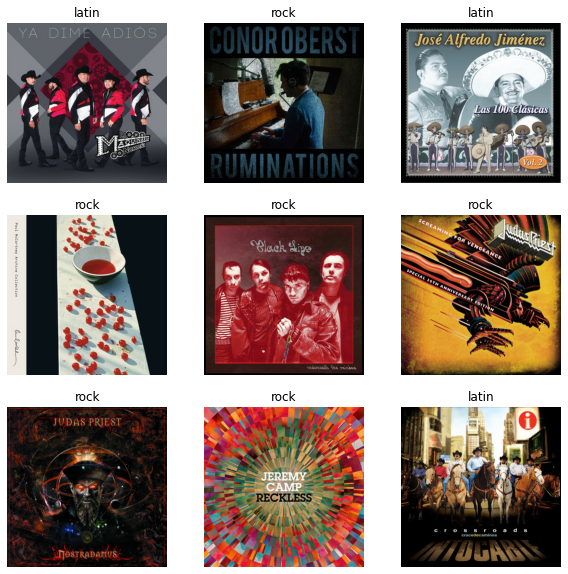

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(2):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 300, 300, 3)
(32,)


In [8]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

### Base Model

Start without transfer learning or drop out

In [12]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [13]:
history = model.fit(train_ds,
                    epochs=5,
                    validation_data=val_ds)

Epoch 1/5
96/96 [==============================] - 212s 2s/step - loss: 0.8960 - accuracy: 0.5825 - val_loss: 0.6452 - val_accuracy: 0.6389
Epoch 2/5
96/96 [==============================] - 225s 2s/step - loss: 0.6124 - accuracy: 0.6744 - val_loss: 0.6401 - val_accuracy: 0.6623
Epoch 3/5
96/96 [==============================] - 216s 2s/step - loss: 0.5086 - accuracy: 0.7506 - val_loss: 0.7364 - val_accuracy: 0.6506
Epoch 4/5
96/96 [==============================] - 176s 2s/step - loss: 0.3883 - accuracy: 0.8232 - val_loss: 0.8263 - val_accuracy: 0.6701
Epoch 5/5
96/96 [==============================] - 144s 2s/step - loss: 0.2962 - accuracy: 0.8740 - val_loss: 1.0026 - val_accuracy: 0.6636


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 149, 149, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 32)        9

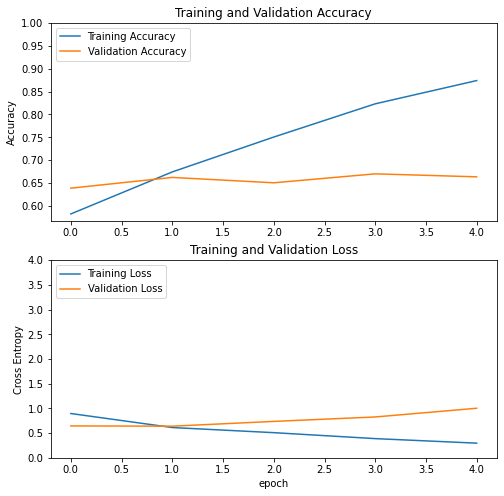

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)

In [17]:
y_prob = model.predict(val_ds)

24/24 [==============================] - 9s 367ms/step


In [18]:
y_predict = y_prob.argmax(axis=-1)

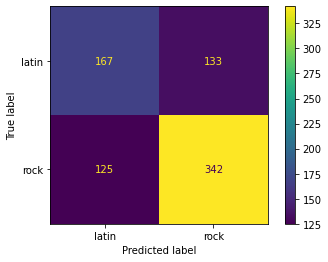

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=class_names)
disp.plot()

Hmm Pretty bad :(, looks like we're overfitting a bit. Perhapps dropout can help.

### With Dropout added to our model

In [27]:
num_classes = 2

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.80, seed = 123),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [28]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [29]:
history = model.fit(train_ds,
                    epochs=10,
                    validation_data=val_ds)

Epoch 1/20
96/96 [==============================] - 201s 2s/step - loss: 0.7257 - accuracy: 0.5965 - val_loss: 0.6614 - val_accuracy: 0.6167
Epoch 2/20
96/96 [==============================] - 391s 4s/step - loss: 0.6547 - accuracy: 0.6216 - val_loss: 0.6621 - val_accuracy: 0.6154
Epoch 3/20
96/96 [==============================] - 396s 4s/step - loss: 0.6332 - accuracy: 0.6516 - val_loss: 0.6227 - val_accuracy: 0.6806
Epoch 4/20
96/96 [==============================] - 363s 4s/step - loss: 0.5947 - accuracy: 0.6793 - val_loss: 0.6115 - val_accuracy: 0.6714
Epoch 5/20
96/96 [==============================] - 496s 5s/step - loss: 0.5546 - accuracy: 0.7151 - val_loss: 0.6818 - val_accuracy: 0.6649
Epoch 6/20
96/96 [==============================] - 522s 5s/step - loss: 0.5181 - accuracy: 0.7398 - val_loss: 0.5911 - val_accuracy: 0.6949
Epoch 7/20
96/96 [==============================] - 557s 6s/step - loss: 0.4945 - accuracy: 0.7561 - val_loss: 0.6043 - val_accuracy: 0.6884
Epoch 8/20
96

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 298, 298, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 149, 149, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 147, 147, 32)      9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 73, 73, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 71, 71, 32)       

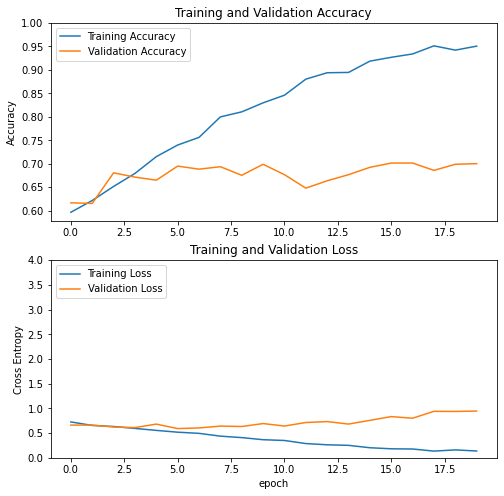

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [32]:
y_actual = np.concatenate([y for x, y in val_ds], axis=0)
y_prob = model.predict(val_ds)
y_predict = y_prob.argmax(axis=-1)

24/24 [==============================] - 13s 466ms/step


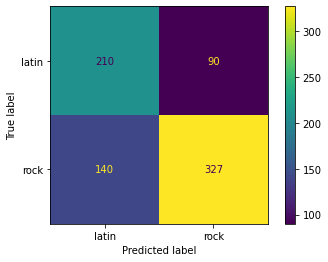

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_matrix = confusion_matrix(y_actual, y_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=con_matrix,
                               display_labels=class_names)
disp.plot()